In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from __future__ import division
from __future__ import print_function

degtorad = np.pi/180.

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
def theta2_from_Snells_law(angle1, n1, n2):
    return np.arcsin(np.sin(angle1) * n1 / n2)

def reflectance_TE(angle1, n1, n2):
    angle2 = theta2_from_Snells_law(angle1, n1, n2)
    temp = n1*np.cos(angle1) - n2*np.cos(angle2)
    temp = temp / (n1*np.cos(angle1) + n2*np.cos(angle2))
    return temp**2

def transmittance_TE(angle1, n1, n2):
    return 1.0 - reflectance_TE(angle1, n1, n2)

n1 = 1.46
n2 = 3.6
for angle in range(0,90,5):
    print(angle, reflectance_TE(angle*degtorad, n1, n2), transmittance_TE(angle*degtorad, n1, n2))
print( ( (n1-n2) / (n1+n2))**2 )

0 0.178865472043 0.821134527957
5 0.179973379145 0.820026620855
10 0.183334047056 0.816665952944
15 0.189059888997 0.810940111003
20 0.19734353503 0.80265646497
25 0.208465839665 0.791534160335
30 0.222807247586 0.777192752414
35 0.240862582488 0.759137417512
40 0.263259199158 0.736740800842
45 0.29077818309 0.70922181691
50 0.324377845946 0.675622154054
55 0.365218099039 0.634781900961
60 0.414683353175 0.585316646825
65 0.474400389054 0.525599610946
70 0.54624623136 0.45375376864
75 0.632339604707 0.367660395293
80 0.735008340143 0.264991659857
85 0.856724550981 0.143275449019
0.178865472043


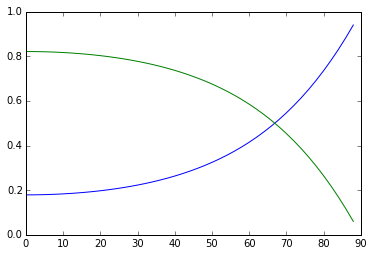

In [3]:
n1 = 1.46
n2 = 3.6
angles = []
R = []
T = []
for angle in range(0,90,2):
    angles = np.append(angles, angle)
    R = np.append(R, reflectance_TE(angle*degtorad, n1, n2))
    T = np.append(T, transmittance_TE(angle*degtorad, n1, n2))
fig, ax = plt.subplots(1,1)
ax.plot(angles, R)
ax.plot(angles, T)

In [4]:
class rayThroughPlanarInterfaces():
    
    def __init__(self, ray_dist_from_axis=0.0, angle_rad=0.0, refr_index=1.0, start_location_on_axis=0.0):
        self.h = np.array([ray_dist_from_axis])
        self.ang_rad = np.array([angle_rad])
        self.refr_index = np.array([refr_index])
        self.location_on_axis = np.array([start_location_on_axis])
        self.normpower_in_ray = np.array([1.0])
        
    def propagate_to_and_thru_new_surface(self,l,new_refr_index):
        self.normpower_in_ray = np.append(self.normpower_in_ray, 
                                          self.normpower_in_ray[-1] * 
                                          transmittance_TE(self.ang_rad[-1],self.refr_index[-1],new_refr_index))
        self.location_on_axis = np.append(self.location_on_axis, self.location_on_axis[-1] + l)
        delta_h = l*np.tan(self.ang_rad[-1])
        self.h = np.append(self.h, self.h[-1] + delta_h)
        new_angle = np.arcsin(np.sin(self.ang_rad[-1])*self.refr_index[-1]/new_refr_index)
        self.ang_rad = np.append(self.ang_rad, new_angle)
        self.refr_index = np.append(self.refr_index, new_refr_index)
        
    def print_values(self):
        print('location_on_axis', 'h', 'ang_rad', 'refr_index', 'normalized power')
        print(self.location_on_axis, self.h, self.ang_rad, self.refr_index, self.normpower_in_ray)
        
test = rayThroughPlanarInterfaces(ray_dist_from_axis=0.0, angle_rad=80.0*degtorad, refr_index=1.33, start_location_on_axis=0.0)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 1.46)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 3.6)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 3.6)
test.print_values()

location_on_axis h ang_rad refr_index normalized power
[ 0.] [ 0.] [ 1.3962634] [ 1.33] [ 1.]
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.] [ 0.          5.67128182] [ 1.3962634   1.11320538] [ 1.33  1.46] [ 1.          0.77656438]
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.  2.] [ 0.          5.67128182  7.70193685] [ 1.3962634   1.11320538  0.37237829] [ 1.33  1.46  3.6 ] [ 1.          0.77656438  0.42026779]
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.  2.  3.] [ 0.          5.67128182  7.70193685  8.09253861] [ 1.3962634   1.11320538  0.37237829  0.37237829] [ 1.33  1.46  3.6   3.6 ] [ 1.          0.77656438  0.42026779  0.42026779]


In [44]:
angle_deg = 80.0
angle_rad = angle_deg * degtorad
print(angle_deg, angle_rad, degtorad)
print(1.0 * np.tan(angle_rad))

80.0 1.3962634016 0.0174532925199
5.67128181962


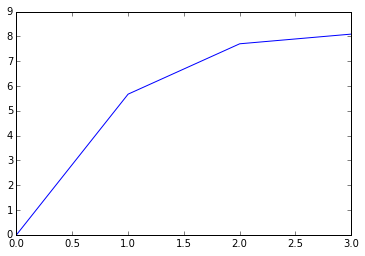

In [45]:
fig, ax = plt.subplots(1,1)
ax.plot(test.location_on_axis, test.h)

In [5]:
thicknesses = np.array([1.0, 1.0, 4.0])
refractive_indices = np.array([1.46, 3.6, 3.6])
initial_refr_index = 1.33
start_location_on_axis = 0.0
array_of_rays = []
for i, angle in enumerate(range(-80,90,10)):
    array_of_rays.append(rayThroughPlanarInterfaces(ray_dist_from_axis = 0.0, 
                                                    angle_rad = angle*degtorad, 
                                                    refr_index = initial_refr_index, 
                                                    start_location_on_axis = start_location_on_axis))
    for l,n in zip(thicknesses, refractive_indices):
        array_of_rays[i].propagate_to_and_thru_new_surface(l, n)

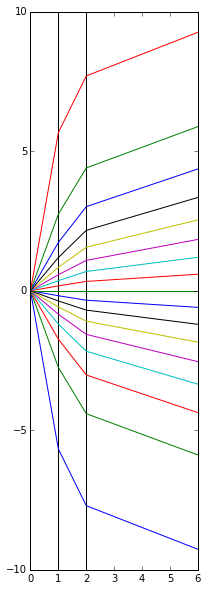

In [6]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
for ray in array_of_rays:
    ax.plot(ray.location_on_axis, ray.h)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-10,10)

cmap=plt.get_cmap('Blues')

See http://matplotlib.org/examples/color/colormaps_reference.html for a good colormap reference

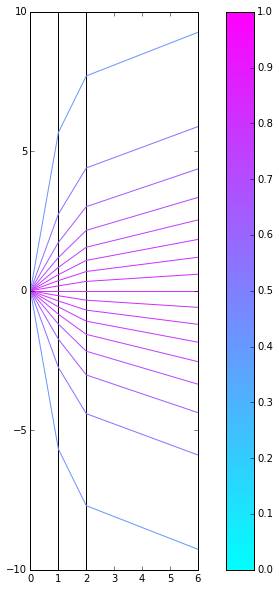

In [26]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa
plt.colorbar(scalarMap)

for ray in array_of_rays:
    colorVal = scalarMap.to_rgba(ray.normpower_in_ray[-1])
    ax.plot(ray.location_on_axis, ray.h, color=colorVal)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-10,10)


In [7]:
thicknesses = np.array([1.0, 2.0, 1.0])
refractive_indices = np.array([1.33, 1.46, 3.6])

for l, n in zip(thicknesses, refractive_indices):
    print(l, n)

1.0 1.33
2.0 1.46
1.0 3.6


In [14]:
for i, angle in enumerate(range(-80,80,10)):
    print(i, angle)

0 -80
1 -70
2 -60
3 -50
4 -40
5 -30
6 -20
7 -10
8 0
9 10
10 20
11 30
12 40
13 50
14 60
15 70
